<a href="https://colab.research.google.com/github/JaeminKIM-Irene/FC_AI_ML_Project/blob/main/irenekim/ML_Project_Baseline_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install xgboost optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold
from functools import partial

from sklearn.metrics import roc_auc_score

import optuna

from sklearn.model_selection import StratifiedKFold
from functools import partial

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read data
result_list = []
base_url = './playground-series-s3e23/'
train = pd.read_csv(base_url+'train.csv', index_col='id')
test = pd.read_csv(base_url+'test.csv', index_col='id')
submission = pd.read_csv(base_url+'sample_submission.csv', index_col='id')

with pd.option_context('display.min_rows', 6) :
  display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


In [ ]:
# data split for baseline model
from sklearn.model_selection import train_test_split

X = train.drop(columns=['defects'])
y = train.defects

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=6, stratify=y)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(81410, 21) (81410,) (20353, 21) (20353,)


## Baseline Model

In [ ]:
def optimizer(trial, X, y) :
    #max_depth = trial.suggest_int('max_depth', 5, 15)
    max_depth=6
    #colsample_bynode = trial.suggest_float('colsample_bynode', 0.5, 0.8)
    colsample_bynode = 0.5196407298366663
    reg_lambda = trial.suggest_float('reg_lambda', 0.5, 5.0)
    #reg_lambda = 4.6191759538097585
    #learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
    learning_rate=0.03293571843473565
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    #n_estimators = 192


    model = XGBClassifier(max_depth=max_depth,
                            colsample_bynode=colsample_bynode,
                            reg_lambda=reg_lambda,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            evaluation_metric = roc_auc_score,
                            random_state=61)

    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)[:,1]

    auc = roc_auc_score(y_val, y_val_pred)

    return auc

In [ ]:
opt_func = partial(optimizer, X=X_train, y=y_train)

study = optuna.create_study(direction='maximize')
study.optimize(opt_func, n_trials=50)

[I 2023-10-19 18:52:35,926] A new study created in memory with name: no-name-609d7faa-19a7-4b73-bb98-2deb75c16e70
[I 2023-10-19 18:52:37,224] Trial 0 finished with value: 0.7973939664464081 and parameters: {'reg_lambda': 0.998573669611533, 'n_estimators': 151}. Best is trial 0 with value: 0.7973939664464081.
[I 2023-10-19 18:52:38,138] Trial 1 finished with value: 0.7974288107940902 and parameters: {'reg_lambda': 1.5349267178339474, 'n_estimators': 105}. Best is trial 1 with value: 0.7974288107940902.
[I 2023-10-19 18:52:39,382] Trial 2 finished with value: 0.7974260563002024 and parameters: {'reg_lambda': 4.922244322817401, 'n_estimators': 198}. Best is trial 1 with value: 0.7974288107940902.
[I 2023-10-19 18:52:40,516] Trial 3 finished with value: 0.7971897689282621 and parameters: {'reg_lambda': 0.5225272687225345, 'n_estimators': 172}. Best is trial 1 with value: 0.7974288107940902.
[I 2023-10-19 18:52:41,139] Trial 4 finished with value: 0.7970530771690745 and parameters: {'reg_la

In [ ]:
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7974
Best Params:  {'max_depth': 6, 'colsample_bynode': 0.5868936331808812, 'reg_lambda': 3.212598061860882, 'learning_rate': 0.03349458692256137, 'n_estimators': 92}


In [ ]:
# fix max_depth 6
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7975
Best Params:  {'colsample_bynode': 0.6168230097939055, 'reg_lambda': 2.0127253867640773, 'learning_rate': 0.03293571843473565, 'n_estimators': 145}


In [ ]:
# fix max_depth 6 + learning_rate 0.03293571843473565
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7976
Best Params:  {'colsample_bynode': 0.5196407298366663, 'reg_lambda': 0.5198621963041086, 'n_estimators': 142}


In [ ]:
# fix max_depth 6 + learning_rate 0.03293571843473565 colsample_bynode 0.5196407298366663
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7978
Best Params:  {'reg_lambda': 4.5995908437546555, 'n_estimators': 146}


In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
best_params = study.best_trial.params

best_model = XGBClassifier(**best_params,
                            random_state=61)
best_model.fit(X_train, y_train)
print('======Prediction======')
pred_train = best_model.predict_proba(X_train)[:,1]
pred_proba_val = best_model.predict_proba(X_val)[:,1]
pred_val = np.greater_equal(pred_proba_val, 0.5).astype(int)

train_score = roc_auc_score(y_train, pred_train)
val_score = roc_auc_score(y_val, pred_proba_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)
print("Validation Acc : %.4f" % accuracy_score(y_val, pred_val))
print("Validation f1_score : %.4f" % f1_score(y_val, pred_val))

======Prediction======
Train Score : 0.8583
Validation Score : 0.7882
Validation Acc : 0.8142
Validation f1_score : 0.4838


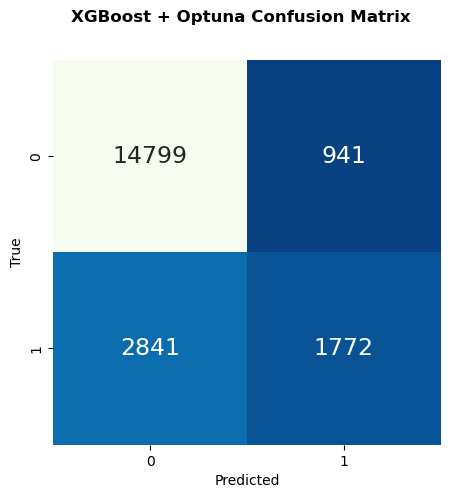

In [ ]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap='GnBu_r', cbar=False, fmt='.0f', annot_kws={"size": 17})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.suptitle('XGBoost + Optuna Confusion Matrix', fontsize=12, fontweight='bold')
    plt.savefig('xgb_optuna.png')
    plt.show()

cm=confusion_matrix(y_val, np.greater_equal(pred_val, 0.5).astype(int))
plot_confusion_matrix(cm)